<img src = "https://scx2.b-cdn.net/gfx/news/hires/2022/ride-into-orbit-secure.jpg" style = "height:360px; width:900px; opacity: 1"/>

# <center> Estimating cropland surfaces based on satellite imagery </center>



The objective of this notebook is to provide a real-world application example of the algorithms presented previously. Note that here the aim is not to achieve excellent results, nor to measure any error, but rather to test the generalizability of the classification algorithm, and how it is combined with the automated segmentation algorithm.

To carry out the application, we use the following procedure: first, we divide the image into several sections. We then use the classification algorithm to label each section (of the terrain), and we segment each section according to its label, so that we can calculate the area of the uncultivated land.

Thereby, the notebook is structured as follows:

1. [Context](#1)
2. [Sampling the image](#2)
3. [Predicting labels](#3)
4. [Processing the image and computing the area](#4)

To start, we first import the libraries that will be used throughout the project.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from math import prod
from collections import Counter
from pywaffle import Waffle

# Import from custom library since its located in another directory
import sys  
sys.path.insert(0, '../Scripts/')
from image_tools import compute_area
from Terrain_segmentation import segment_image

Now, we proceed to define a couple of functions to manipulate the images. `get_subsamples` will return a matrix with the sections (of identical size) of the image after cropping it. `bound_matrix` simply creates a frame that can be tailored in size, position, thickness and color, as shown below. Finally, `process_image`, which features **get_subsamples**, processes the image, that is, crop the image, then tag each section and apply the segmentation algorithm (**segment_image**) to it, and compute the area using **compute_area**. 

In [4]:
def get_subsamples(image, sample_size):
    
    img_height, img_width, n_channels = image.shape if len(image.shape) == 3 else image.shape + (1,)
    sample_height, sample_width = sample_size
    n_row = img_height//sample_height + 1 * (img_height % sample_height > 0)
    n_col = img_width//sample_width + 1 * (img_width % sample_width > 0)
    
    set_subsample = np.zeros((n_row , n_col, sample_height, sample_width, n_channels)) if n_channels > 1 else \
                    np.zeros((n_row , n_col, sample_height, sample_width))
    
    for col in range(n_col):
        
        if col == n_col-1:
            for row in range(n_row):
                if row == n_row-1:
                    set_subsample[row, col] = image[-sample_height: , -sample_width:]
                    
                else:
                    set_subsample[row, col] = image[row*sample_height: (row+1)*sample_height, -sample_width:]
        else:
            for row in range(n_row):
                if row == n_row-1:
                    set_subsample[row, col] = image[-sample_height: , col*sample_width: (col+1)*sample_width]

                else:
                    set_subsample[row, col] = image[row*sample_height: (row+1)*sample_height, col*sample_width: (col+1)*sample_width]
            
    return set_subsample

In [5]:
def bound_matrix(matrix_size, bound_shape, init_pos, s, color):
    n_row, n_col = bound_shape
    x, y = init_pos
    m = np.zeros(matrix_size)
    m[y:y+s, x : x + n_col, :], m[y-s + n_row: y + n_row, x: x + n_col, :] = 1, 1
    m[y: y + n_row, x:x+s, :], m[y : y + n_row, x-s+n_col: x + n_col, :] = 1, 1
    m[:, :, 0] *= color[0]
    m[:, :, 1] *= color[1]
    m[:, :, 2] *= color[2]

    return m

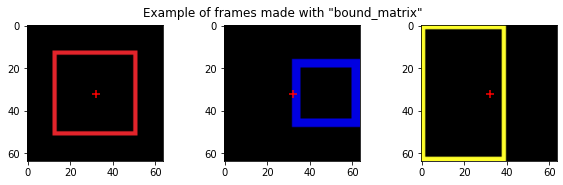

In [6]:
m = [bound_matrix((64, 64, 3), (40, 40), (12, 12), 2, (227, 36, 43)),
     bound_matrix((64, 64, 3), (32, 32), (32, 16), 4, (0, 0, 225)),
     bound_matrix((64, 64, 3), (64, 40), (0, 0), 2, (255, 255, 43))]

fig, ax = plt.subplots(1, 3, figsize = (10, 2.5))
for i in range(3):
    ax[i].imshow(m[i].astype(np.uint8))
    ax[i].scatter([32], [32], marker = '+', color = 'r', s = 50)

plt.suptitle('Example of frames made with "bound_matrix"')
plt.show()

In [7]:
def process_image(image, model, sample_size = (64, 64), return_area = False, hide_frame = True):
    # Parameters for segmentation
    params = {'n_clusters':{'SeaLake': 1, 'AnnualCrop': 4, 'HerbaceousVegetation': 3, 'Residential': 4, 'River': 6, \
                        'Pasture': 5, 'Industrial': 2, 'Highway': 2, 'PermanentCrop': 5, 'Forest': 2},
              
          't_method': {'SeaLake': 'binary_inv', 'AnnualCrop': 'binary', 'HerbaceousVegetation': 'binary_inv', \
                       'Residential': 'binary_inv', 'River':'trozero_inv', 'Pasture': 'binary', 'Industrial': 'binary', \
                      'Highway': 'binary_inv', 'PermanentCrop': 'trozero', 'Forest': 'binary_inv'},
          
          'thresh': {'SeaLake': 0.3, 'AnnualCrop': 0.3, 'HerbaceousVegetation': 0.3, 'Residential': 0.3, 'River': 0.35, \
                        'Pasture': 0.8, 'Industrial': 0.6, 'Highway': 0.5, 'PermanentCrop': 0.7, 'Forest': 0.6}
              }
    area = 0
    subsamples = get_subsamples(image, sample_size)
    
    img_height, img_width, n_channels = image.shape if len(image.shape) == 3 else image.shape + (1,)
    sample_height, sample_width = sample_size
    res_height, res_width = img_height % sample_height, img_width % sample_width
    # Initialize row if contour images
    img_contour = np.zeros((sample_height, img_width + sample_width, n_channels))
    
    for row_index, row in enumerate(subsamples):
        # Initialize contour image
        row_contour_img = np.zeros((sample_height, sample_width, n_channels))

        for col_index, img in enumerate(row):
            # Predict sampled image label
            predicted = model.predict(np.expand_dims(img, 0))
            label = class_names[np.argmax(predicted[0])]
            # Select parameters for segmentation
            n_clusters = params['n_clusters'][label]
            thresh = params['thresh'][label]
            t_method = params['t_method'][label]
            # Resize bounding samples
            if row_index == subsamples.shape[0] - 1:
                img = img[-res_height:, :, :]
            if col_index == subsamples.shape[1] - 1:
                img = img[:, -res_width:, :]
            # Segment sampled image
            try:
                s_img, c_img, ctrs = segment_image(img, n_clusters = n_clusters, thresh = thresh, t_method = t_method)
                # removing the frame from contour image
                if hide_frame:
                    c_img[0, :sample_width, :], c_img[-1, :sample_width, :] = 0, 0
                    c_img[:sample_height, 0, :], c_img[:sample_height, -1, :] = 0, 0
                    
            except: 
                print('Error in row {}, col {}'.format(row_index, col_index))
                s_img = np.zeros_like(img)
                c_img = np.zeros_like(img)
                ctrs = ()

            # Concatenate contour images within a row
            row_contour_img = np.hstack((row_contour_img, c_img))

            try:
                area += compute_area(ctrs) if label not in ['SeaLake', 'Industrial', 'River'] else 0
            except:
                area += 0
                
        # Concatenate the rows of contour images 
        img_contour = np.vstack((img_contour, row_contour_img))
    # Remove image blocks from initialization
    img_contour = img_contour[sample_height:, sample_width:, :]
    
    return (img_contour, area) if return_area else img_contour

<a id="1"></a>
## Context

Before presenting the image used in this experiment, we will first specify the directory containing the image.

In [8]:
path = "../Data/Other"

Let's start with the demonstration. In this example, we have selected a 10m resolution satellite image of agricultural production, where we can see different types of land, from uncultivated land to various types of plantations, as well as roads and highways, and small buildings. 
<br> Since the original image is quite large (2560x1920) and to ensure a fast execution, we preferred to resample the image in order to reduce its size without compromising the quality of the image excessively. The resulting image maintains a good quality, so it can be used without any problems.

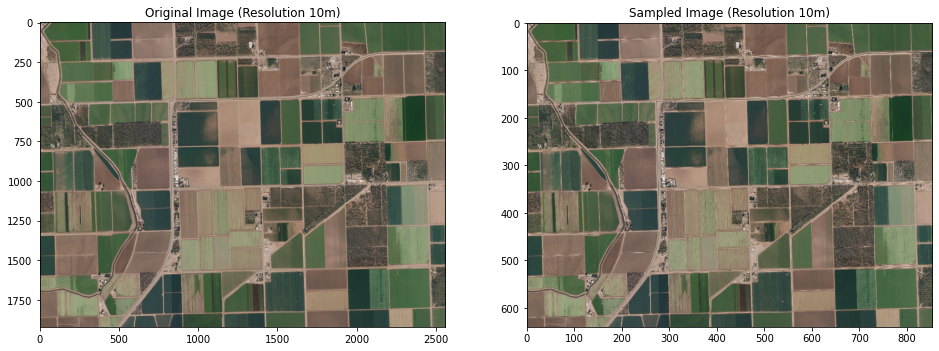

In [9]:
# Load image
farmland_image = plt.imread('{}/farmland_image.jpg'.format(path))
# Subsampling
farmland_image = farmland_image[::3, ::3, :]

fig, ax = plt.subplots(1, 2, figsize = (16, 7))
ax[0].set_title('Original Image (Resolution 10m)')
ax[0].imshow(plt.imread('{}/farmland_image.jpg'.format(path)))
ax[1].imshow(farmland_image)
ax[1].set_title('Sampled Image (Resolution 10m)')
plt.show()

<a id="2"></a>
## Sampling the image

The first step is to divide the image into small samples, in this case 64x64, since the classification algorithm is trained on images of this size. 

In [10]:
subsamples = get_subsamples(farmland_image, (64, 64))
print("Total samples: {} ({} rows, {} columns), sample size: {}".format(prod(subsamples.shape[:2]), subsamples.shape[0], \
                                                                            subsamples.shape[1], subsamples.shape[2:]))

Total samples: 140 (10 rows, 14 columns), sample size: (64, 64, 3)


We have a matrix that has 10 rows and 14 columns for a total of 140 samples. Note that if the length or height of the image were not multiples of the length or height of the samples (here 64), there would be pieces of smaller size, making them unreadable for labeling. Therefore, the solution we chose is to fill the last image sample, if the image size is not a multiple of 64, by including a number of pixels from the previous sample until it matches the specified sample size, i.e. 64x64. Filling the empty pixels with a particular color would not be an appropriate solution, because the classification algorithm would not be able to classify the sample. Therefore, our method is less disruptive as it considers the context of the image, and is convenient in that it is a simple solution that does not require us to delve deeper into the subject. The following figure shows the output of the sampling function, with the pixels that were duplicated for the last sample framed in red, since the width of the image is not a multiple of 64.


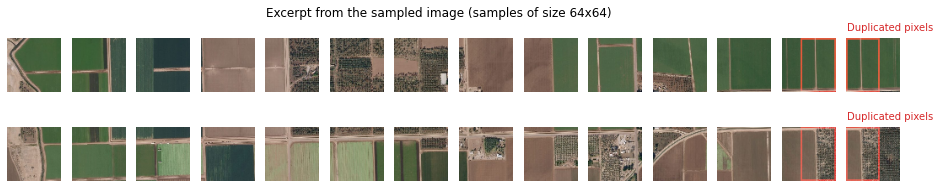

In [11]:
fig, ax = plt.subplots(2, 14, figsize = (16, 3))

for idx in range(2):
    for i in range(14):
        if i < 12:
            ax[idx, i].imshow(subsamples[idx, i].astype(np.uint8))
            
        if i == 12:
            m = bound_matrix((64, 64, 3), (64, 42), (22, 0), 2, [227, 36, 43])
            mn = np.zeros_like(m)
            for row in range(m.shape[0]):
                for col in range(m.shape[1]):
                    for cn in range(m.shape[2]):
                        mn[row, col, cn] = max(m[row, col, cn], subsamples[idx, i][row, col, cn])
            ax[idx, i].imshow(mn.astype(np.uint8))

        if i == 13:
            m = bound_matrix((64, 64, 3), (64, 40), (0, 0), 2, [227, 36, 43])
            mn = np.zeros_like(m)
            for row in range(m.shape[0]):
                for col in range(m.shape[1]):
                    for cn in range(m.shape[2]):
                        mn[row, col, cn] = max(m[row, col, cn], subsamples[idx, i][row, col, cn])
            ax[idx, i].imshow(mn.astype(np.uint8))
            ax[idx, i].text(0, -10, 'Duplicated pixels', color = 'tab:red')

        ax[idx, i].axis('off')
        
plt.suptitle('Excerpt from the sampled image (samples of size 64x64)')
plt.show()

<a id="3"></a>
## Predicting labels

The extracted patches are then classified according to the type of terrain to which they correspond. We use a model based on a Xception type convolutional neural network, trained with a little over 20,000 images. 

In [12]:
# Load the model
keras_model = tf.keras.models.load_model('../Models/baseline_model')

class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

In [13]:
%%time
# Predict the labels
predicted = [keras_model.predict(np.expand_dims(img, 0)) for x in subsamples for img in x]
predicted_classes = [class_names[np.argmax(x[0])] for x in predicted]

Wall time: 45.9 s


Labeling the 140 samples took little time, but it is necessary to evaluate whether these classifications are accurate. Since the original image is arbitrary and not present in the images used for model evaluation, there is no indication of the true category of each sample. That is, we can only detect the most abnormal predictions. 

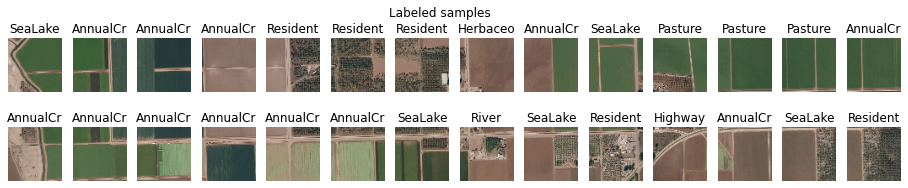

In [14]:
fig, ax = plt.subplots(2, 14, figsize = (16, 3))

for nb, x in enumerate(subsamples[:2]):
    for i, img in enumerate(x):
        ax[nb, i].imshow(img.astype(np.uint8))
        ax[nb, i].set_title('{}'.format(predicted_classes[14*nb+i])[:8])
        ax[nb, i].axis('off')

    
plt.suptitle('Labeled samples')
plt.show()

On a visual level, there are a few mistakes, such as attributing "lake" to a section of land that clearly does not belong in that category, or assigning "river" to a land parcel that contains a structure. 
These anomalous predictions are indicative of a lack of ability of the model to generalize, i.e., it either needs more training  (using images from other sources or data augmentation techniques), or the images processed must all be of the same resolution as the training ones. Apart from that, we see that doubling some pixels in the last sample of each column produces quite reasonable predictions.

Considering that the model (not the architecture itself) needs to be improved, and to understand where it fails, we decided to plot the distribution of the predicted labels. It's worth noting that the 'SeaLake' category is not supposed to be present at all, and that there may be some mix-ups between other categories, particularly between 'AnnualCrop' and 'PermanentCrop'.  

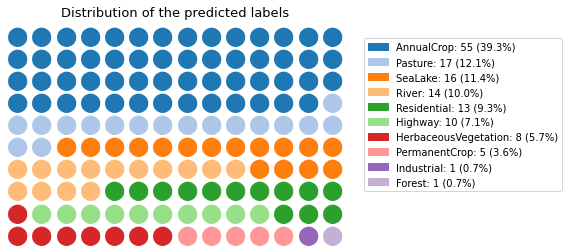

In [15]:
data = dict(Counter(predicted_classes).most_common())
fig, ax = plt.subplots(figsize = (6, 4))

Waffle.make_waffle(
    ax=ax,
    rows=10,
    columns=14,
    values=data,
    title={'label': 'Distribution of the predicted labels', 'loc': 'center', 'fontdict': {'fontsize': 13}},
    labels=[f"{k}: {v} ({np.round(v / sum(data.values()) * 100, 1)}%)" for k, v in data.items()], 
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 0.95), 'ncol': 1},
    cmap_name="tab20", 
    block_arranging_style='snake', 
    vertical = True,
    starting_location='NE',
    characters='⬤',
    font_size=19
    )

plt.show()

These results show a great proportion of AnnualCrop (39.3%), but considering the image in question, it looks significantly low.
<br> Next is Pasture with 12.1%, which makes sense since several sections are entirely green, which would influence the classification algorithm.
<br> For SeaLake (11.4%) and River (10%), however, such a large proportion is a major setback as there is no water in the image. 
However, for River, we could consider a confusion with Highway, as shown in the __[classification](https://github.com/achrafkr/Satellite-Imaging/blob/main/Cropland%20Estimation/Notebooks/Terrain_classification.ipynb)__ Notebook, yet the large amount in proportion reveals the limitations of the classification algorithm. 
<br> Meanwhile, considering the buildings scattered throughout the terrain, it seems reasonable to achieve such results for Residential and Industrial. <br> In the same way, the proportion of Highway labels seems consistent with the image since several dirt roads are visible, and should even be a slightly higher given the confusion with River. A similar situation is also found in HerbaceousVegetation, where certain sections are likely to lead to such predictions. 
<br> Lastly, on a testimonial basis, we have Forest, which is indicative of a minor anomaly.

<a id="4"></a>
## Processing the image and computing the area

The last step, once the classification is performed, is to segment the every sample and compute the uncultivated area. 
The `process_image` function is indispensable to perform the whole series of transformations, since it performs all the operations previously described. In addition, it segments all the slices of the image and extracts the contour of the terrain of interest, in order to estimate the area of the contour. As output, we get the reconstructed image showing the contours and, as an option, the area. Notice that the resulting image has the same size as the input, this is due to the fact that the segmentation algorithm doesn't require the slices to have a specific size, so we can just remove the duplicated pixels from the last column of samples and apply the algorithm.

In [16]:
%%time
image_contour, area = process_image(farmland_image, keras_model, return_area = True)

Wall time: 14.7 s


In [17]:
area, prod(farmland_image[:2].shape)*100

(165924.0, 512400)

To estimate the area coverage, we multiply the squared resolution (of the satellite image) by the number of pixels.

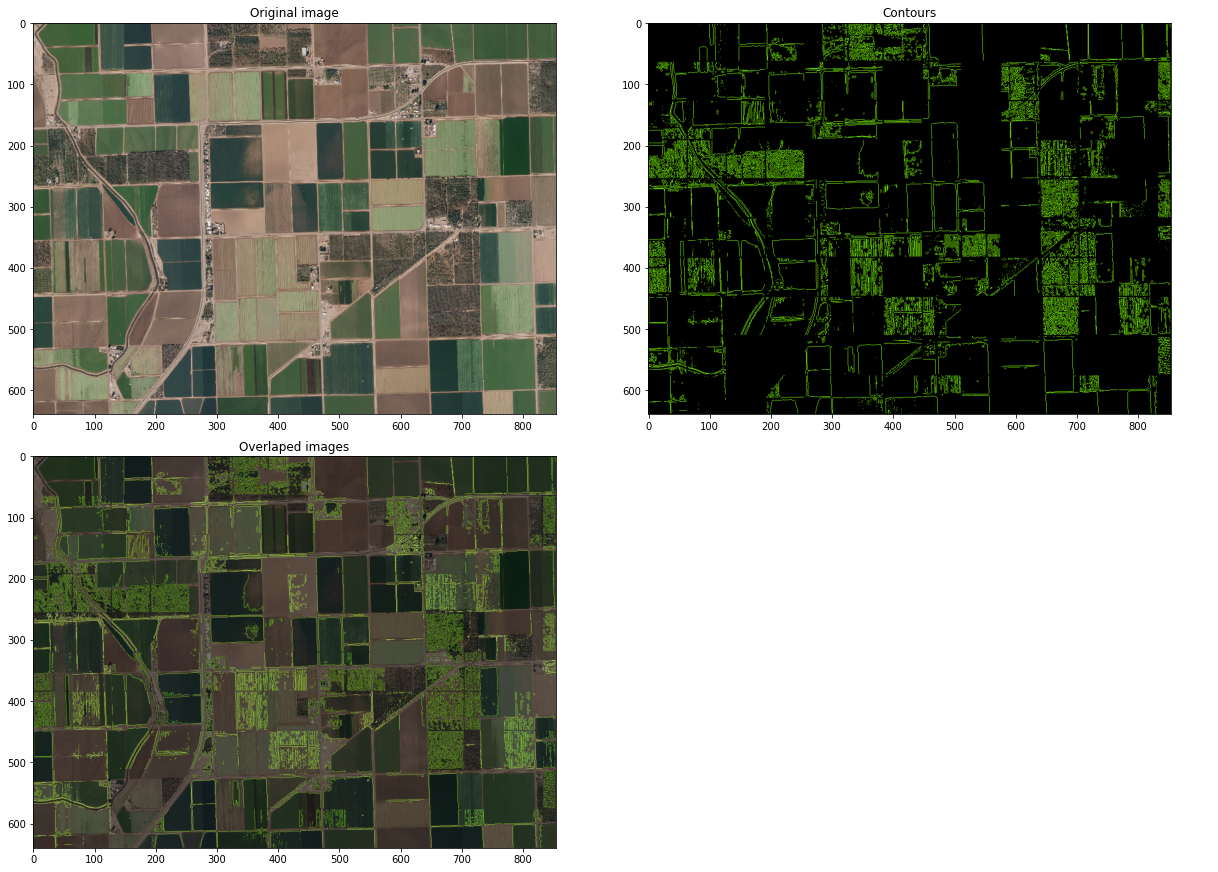

In [18]:
fig, ax = plt.subplots(2, 2, figsize = (17, 12), layout='constrained')

ax[0, 0].imshow(farmland_image.astype(np.uint8))
ax[0, 0].set_title('Original image')
ax[0, 1].imshow(image_contour.astype(np.uint8))
ax[0, 1].set_title('Contours')
ax[1, 0].imshow((farmland_image + image_contour)/510.)
ax[1, 0].set_title('Overlaped images')
ax[1, 1].axis('off')
plt.show()

The results achieved from applying the classification and segmentation algorithms are promising considering the time invested, as well as the shallow character algorithms used. Within this exercise, we have been obtaining insights to improve our approach in the future. 

First, it seems apparent that the generalization problems of the classification algorithm prevent a better segmentation of the terrain since several parameters of the segmentation algorithm depend on the category assigned during classification. To address this issue, it appears to be beneficial to apply data augmentation techniques, as discussed in the classification notebook. An alternative solution could be to replace the classification model by another one based on masks (Mask R-CNNs), however this solution would be more complex since there is no abundance of labeled data for training and an arduous task would be the creation of such data. Finally, we could use the context of each section, and then generate a coefficient for classification that considers as well the output of the adjacent sections, relying on clustering or kNN algorithms, for instance. While not perfect, this solution could enhance the performance and, therefore, reduce inconsistencies such as getting "SeaLake" and "River" in an image without water.

If major errors are mainly caused by classification, segmentation is not without downsides either. Here, the importance of choosing good settings for each particular case is emphasized, thereby limiting the achievement of a fully automated algorithm. As with classification, an improvement in segmentation quality could be achieved by using Mask R-CNN based algorithms, which would create a less porous surface for certain challenging spots, and thus enhance the accuracy of the estimated area.
<br> These improvements, however, would be at the expense of both the time to construct a sufficiently large and high quality training dataset and the amount of resources required to train the model.